# Hyperlocal Air Quality Prediction

### Introduction

The [Environmental Defense Fund (EDF)](https://www.edf.org/airqualitymaps) has partnered with Google Earth Outreach to map air pollution at the **hyperlocal level**. In various cities around the world, mobile air quality sensors were used to gather air pollution data at street level. This new approach allows researchers to collect much more data at a granular level and showed how air poluution varied over very short distances. 

Our project focuses on the data collected in [Houston](https://www.edf.org/airqualitymaps/houston), where low cost mobile sensors were outfitted on city fleet vehicles and Google Street View cars, in addition to gathering data from stationary sensors. For this report, we have focused on only one type of pollution - NO2 emissions.

Based on our review of literature and exploring various datasets, we have decided the scope of our project to explore the use of machine learning models to predict air quality at any location in Houston based on meteorlogical conditions, sources of emissions from various facilities, and traffic.

### Inspiration

Our project is inspired and informed by Varsha Gopalakrishnan's "Hyperlocal Air Quality Prediction using Machine Learning" project, outlined on [Medium](https://towardsdatascience.com/hyperlocal-air-quality-prediction-using-machine-learning-ed3a661b9a71). Gopalakrishnan performed her analysis using Oakland data, and we intend to replicate most aspects of the approach for Houston.

### Data

The level of pollution at any place depends on a number of factors like traffic on major streets; emissions from different facilities like railroads, ports, and industries; and meteorological factors like temperature and precipitation. Our target variable is Air Quality Data obtained from the aforementioned pilot done by EDF. We conducted exploratory data analysis for the air quality dataset in our [Houston air quality data Jupyter Notebook](https://github.com/vjoseph21/air-quality-prediction/blob/main/notebooks/cleaning/air_quality.ipynb).

We classified our potential features into the following three buckets:

#### 1. Traffic Data - [Link to notebook](https://github.com/vjoseph21/air-quality-prediction/blob/main/notebooks/cleaning/traffic_data.ipynb)
We look at the geographical range for which EDF collected the air quality data in Houston. The coordinates for the area around Houston is based on minimum and maximum of latitude and longitude from the EDF data. We chose this area as the bounding box to determine location of all traffic signals / intersections within that boundary.

The Overpass API from Open Street Maps is used to determine the location of all traffic signals (intersections) within a given bounding box. The Overpy library is used to send the request to the API and this call returns the latitude and longitude of all traffic signals. Next, the distance between each traffic intersection and each point in the monitoring data is measured. A traffic score is calculated as the 'Number of traffic intersections within 1,000 ft of each point in the monitoring data."

Going forward, in addition to intersections, we will also extend the analysis to look at the distance of bus stops and highways from the NO2 monitoring points.

#### 2. Emissions Data - [Link to notebook](https://github.com/vjoseph21/air-quality-prediction/blob/main/notebooks/cleaning/facility_data.ipynb)

We use NEI's data for point sources - which provides facility specific pollutant information from across the US. Similar to how we bound based on a boundary box region, we consider only those facilities that fall within the (lat, long) range for which EDF data was collected.

After grouping some of the sources based on their types and range of emission values, we calculate the distance between the location of every pollutant data read (from the EDF data) to each facility. We also calculate the emissions per distance measure for each such row, with the idea being that both the quantity of NO2 emission from the facility, as well as the distance from the facility will affect NO2 concentration at a certain point

Going forward, we will invest time on three fronts:
1. Understanding sources currently marked as 'unknown', since they could add vital information (and variance) to the dataset
2. Carrying out a more robuts outlier treatment of the NO2 distribution
3. Calculating additional aggregated numeric metrics such as number of point sources (per source_group) in a given radius from the monitoring point

#### 3. Meteorological factors - [Link to notebook](https://github.com/vjoseph21/air-quality-prediction/blob/main/notebooks/cleaning/met_data.ipynb)
Following Gopalakrishnan's approach, we use the [Daymet](https://daymet.ornl.gov/web_services) API to collect our meteorological data. Daymet's "daily surface weather and climatological summaries" provide daily data at a 1km grid granularity, extrapolated from less-granular meteorological observations. Through approximately 200 calls to the Daymet API, we gathered the available daily data (maximum temperature, minimum temperature, shortwave radiation, vapor pressure, and precipitation) at latitudes and longitudes corresponding to the locations of our air quality measurements, and produced averages for each metric across the 9 months when EDF was collecting air quality data in Houston.

Going forward, we plan to explore alternate approaches to collapsing the daily data for each air quality measurement site - for example, it's possible that minimums or maximums over the 9-month period in question would be more meaningful than averages.

### Modeling 
We will use this dataset to develop a model to predict air quality in neighbourhoods in Houston where the EDF project did not collect air quality data. We plan to first train the machine learning model to predict NO2 emissions on the same locations as the EDF data and then use the trained model and additional traffic, features, and emissions data to preduct concentrations elsewhere in Houston.

For the baseline model, we have merged all the features mentioned above into one dataset and used linear regression for feature selection. We decided to use a threshold of $\pm90$% to indicate very high correlation between features and dropped them to avoid multicollineairty. We then use the remaining features to run a simple linear regression to guage the siginificance of each feature on NO2 emissions. Our results indicate that minimum temperature, precipitation, and number of intersections are the most important features to predict air quality.

In [1]:
#Import basic python packages for data analysis and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.lines as mlines
import pylab as plot
import matplotlib
import random
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import time

### Import Scipy stats packages
from scipy.stats import pearsonr
from scipy.stats import boxcox


# Import statsmodel packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# import sklearn packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
import pickle

import re
import os


import warnings
warnings.filterwarnings("ignore")

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## (A) Dataset prep

In [2]:
# merge all datasets to create master_df

root = os.path.dirname(os.path.dirname(os.getcwd()))

df_aq = pd.read_csv(root + "/data/cleaned/air_quality_NO2.csv", index_col=0)[['value','latitude', 'longitude']]
df_met = pd.read_csv(root + "/data/cleaned/nO2_met.csv", index_col=0)
df_fac = pd.read_csv(root + "/data/cleaned/no2_fac_data.csv", index_col=0)
# df_fac.drop(df_fac.columns[df_fac.columns.str.contains('_emsdist')], axis=1, inplace=True)
df_traffic = pd.read_csv(root + "/data/cleaned/intersection_final.csv", index_col=0)

df_m1 = df_aq.merge(df_met, on = ['latitude', 'longitude'], how = 'inner')
df_m2 = df_m1.merge(df_fac, on = ['latitude', 'longitude'], how = 'inner')
df_merged = df_m2.merge(df_traffic, on = ['latitude', 'longitude'], how = 'inner')
df_merged.drop(columns = ['latitude', 'longitude'], inplace=True)

X = df_merged.drop("value",1) 
y = df_merged["value"]

## (B) Modeling - Using Cross Validation and Randomized/Grid Search

In [132]:
#NB -- Code to get list of params for an estimator:
#regressor.get_params().keys()

In [3]:
# function to scale and transform input data
def get_data(X, y):
    X = X.values
    y = y.values
    # scaling the data
    feature_scaler = StandardScaler()
    X = feature_scaler.fit_transform(X)
    return X, y

# acquiring transformed data
X_arr, y_arr = get_data(X, y)
cols = np.array(X.columns)

# master list for all model scores
model_scores = {}

### (1) Random forest

Tuning model
Feature selection
Number of selected features: 61
Number of selected features: 51
Number of selected features: 36
Number of selected features: 25
Number of selected features: 16
Number of selected features: 10
Number of selected features: 8
Number of selected features: 4
Number of selected features: 4
Number of selected features: 2
Number of selected features: 1
Saving model to file
MSE before feature selection: -3.549427773120434e-08
MSE after feature selection: -3.554107593003395e-08
The final list of features are: ['prcp' 'srad' 'tmax' '14464611-RailYard-high_dist'
 '14464611-RailYard-high_emsdist' '14487911-RailYard-low_dist'
 '14487911-RailYard-low_emsdist' '14488111-RailYard-high_dist'
 '14488111-RailYard-high_emsdist' '14489211-RailYard-medium_dist'
 '14489211-RailYard-medium_emsdist' '14766711-Institution-medium_dist'
 '14766711-Institution-medium_emsdist' '16926811-RailYard-high_dist'
 '16926811-RailYard-high_emsdist' '17865111-RailYard-medium_dist'
 '17865111-Rai

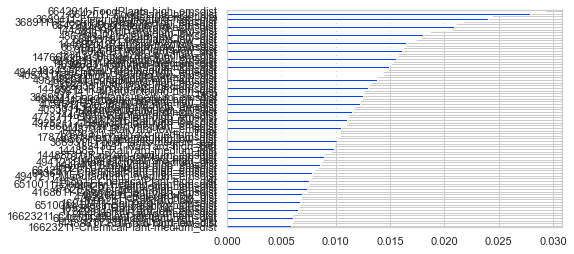

In [4]:
def rf_tuning(X_arr, y_arr, grid_param):
    print("Tuning model")
    # defining the regressor
    regressor = RandomForestRegressor(random_state=0)

    # doing randomized search
    rd_sr = RandomizedSearchCV(estimator=regressor,
                               param_distributions=grid_param,
                               scoring='neg_mean_squared_error',
                               cv=10,
                               n_jobs=-1)

    rd_sr.fit(X_arr, y_arr)

    # best estimator and it's components
    best_parameters = rd_sr.best_params_
    best_est_score = rd_sr.best_score_
    feature_imp = rd_sr.best_estimator_.feature_importances_
    
    return rd_sr, best_parameters, best_est_score, feature_imp
    

def rf_feat_selection(X_arr, y_arr, grid_param, cols):
    rd_sr, best_parameters, best_est_score, feature_imp = rf_tuning(X_arr, y_arr, grid_param)
    
    print("Feature selection")
    # plotting feat imp histogram
    pd.Series(feature_imp, index=cols).sort_values().plot(kind='barh')
    
    # calculating optimum number of features
    high_score = float(-np.inf)
    
    for thresh in np.arange(min(feature_imp) + 0.002, max(feature_imp), 0.002):
        # identify the most important features using threshold (use RFECV or top 10 percentile later)
        sfm = SelectFromModel(rd_sr.best_estimator_, threshold=thresh, prefit=True)
        selected_features = cols[sfm.get_support(indices=True)]
        print("Number of selected features:", len(selected_features))

        # updated dataset
        X_updated = sfm.transform(X_arr)

        # train a second regressor on this new dataset with hyperparameters of best estimators above using CV
        cv_score_list = cross_val_score(RandomForestRegressor(**best_parameters), X_updated, 
                                        y_arr, cv=10, scoring='neg_mean_squared_error')
        
        if cv_score_list.mean() > high_score and len(selected_features) > 10:
            high_score = cv_score_list.mean()
            final_feat_lst = selected_features
            feat_arr = X_updated
            
    return high_score, final_feat_lst, feat_arr, best_parameters, best_est_score


def rf_model(X_arr, y_arr, grid_param, cols):
    high_score, final_feat_lst, feat_arr, best_parameters, \
        best_est_score = rf_feat_selection(X_arr, y_arr, grid_param, cols)

    print("Saving model to file")
    # saving the model to file
    final_model = RandomForestRegressor(**best_parameters)
    final_model.fit(feat_arr, y_arr)
    pkl_filename = "rf_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(final_model, file)

    print("MSE before feature selection:", best_est_score)
    print("MSE after feature selection:", high_score)
    print("The final list of features are:", final_feat_lst)
    print("The final set of hyperparameters are:", best_parameters)
    
    return high_score


grid_param = {
        'n_estimators': [100, 300, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, 40, 50],
        #'min_samples_split': [2, 5, 10, 15, 20],
        #'min_samples_leaf': [1, 2, 5, 10, 15],
        #'bootstrap': [True, False]
    }


# building the model
final_score = rf_model(X_arr, y_arr, grid_param, cols)

# saving tuned model score to master dict
model_scores["Random Forest"] = final_score

### (2) XGBoost

Tuning XGB model
Feature selection


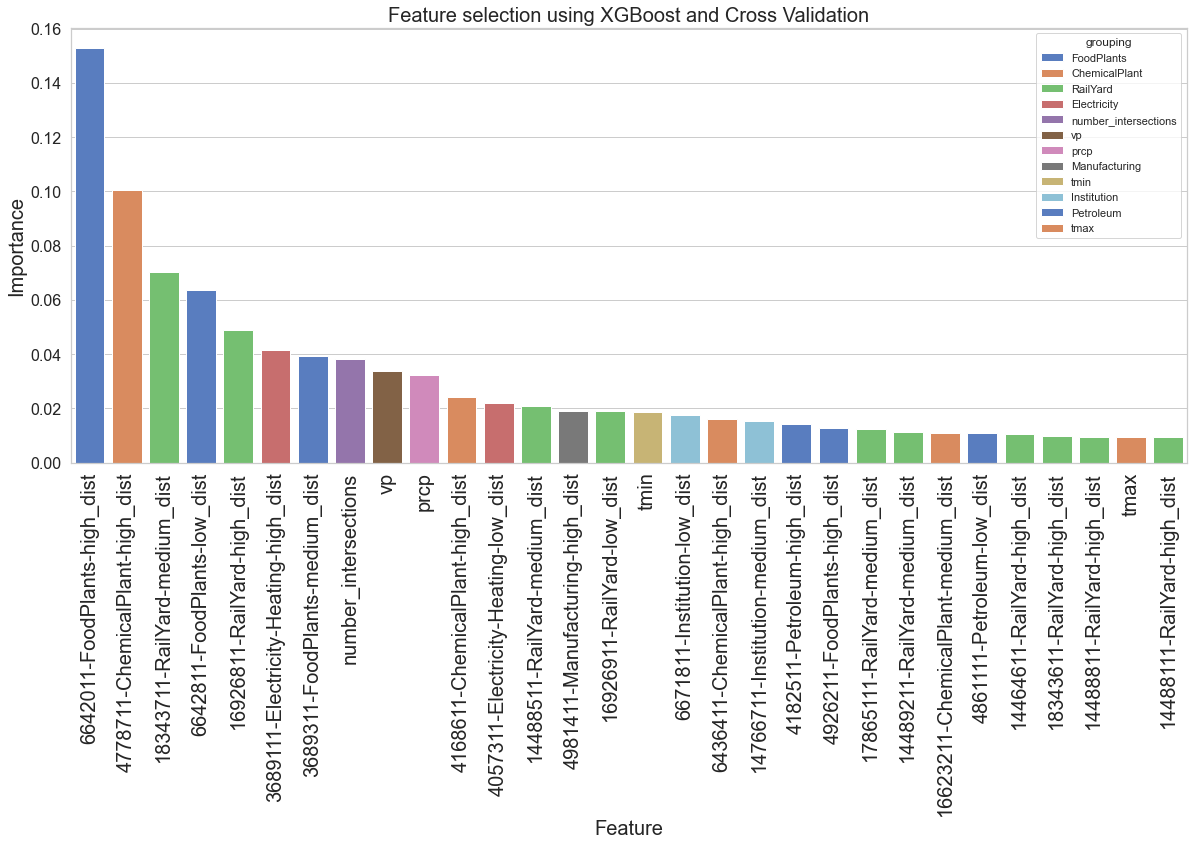

Number of selected features: 44
Number of selected features: 44
Number of selected features: 38
Number of selected features: 30
Number of selected features: 26
Number of selected features: 22
Number of selected features: 20
Number of selected features: 18
Number of selected features: 16
Number of selected features: 13
Number of selected features: 11
Number of selected features: 11
Number of selected features: 10
Number of selected features: 10
Number of selected features: 10
Number of selected features: 10
Number of selected features: 8
Number of selected features: 8
Number of selected features: 8
Number of selected features: 6
Number of selected features: 5
Number of selected features: 5
Number of selected features: 5
Number of selected features: 5
Number of selected features: 4
Number of selected features: 4
Number of selected features: 4
Number of selected features: 4
Number of selected features: 4
Number of selected features: 4
Number of selected features: 4
Number of selected feat

In [5]:
def xgb_tuning(X_arr, y_arr, grid_param):
    print("Tuning XGB model")
    
    # defining the regressor
    
    regressor = XGBRegressor(random_state=0)
    
    # RandomizedSearch
    rd_sr = RandomizedSearchCV(estimator = regressor,
                                   param_distributions = grid_param,
                                   scoring = 'neg_mean_squared_error',
                                   cv = 10,
                                   n_jobs = -1
                                  )
    
    rd_sr.fit(X_arr, y_arr)
    
    # best estimator and its components
    best_parameters = rd_sr.best_params_
    best_est_score = rd_sr.best_score_
    feature_imp = rd_sr.best_estimator_.feature_importances_

    return rd_sr, best_parameters, best_est_score, feature_imp

def plot_hist(data):
    plt.figure(figsize = (20,8))
    ax = sns.barplot(y = 'Importance', x = 'Feature', 
                     hue = 'grouping',  
                     data = data[:30],
                     dodge = False, palette = 'muted')
    plt.xticks(rotation = 90)
    plt.xlabel("Feature", size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 16)
    plt.ylabel("Importance", size = 20)
    plt.title("Feature selection using XGBoost and Cross Validation", size = 20)
    plt.show()

def add_group(data):
    data['grouping'] = " "
    for index, string in enumerate(data['Feature']):
        group = re.findall(r'-(.*?)-', string)
        if group:
            data.loc[index, 'grouping'] = group[0]
        else:
            data.loc[index, 'grouping'] = data.loc[index, 'Feature']
    
def xgb_feat_selection(X_arr, y_arr, grid_param, cols):
    
    rd_sr, best_parameters, best_est_score, feature_imp = xgb_tuning(
        X_arr, y_arr, grid_param)
    
    print("Feature selection")
    # plotting feat imp histogram
    sf = pd.Series(feature_imp, index=cols)
    df = pd.DataFrame({'Feature':sf.index, 'Importance':sf.values})
    df = df.sort_values('Importance', ascending = False).reset_index()
    add_group(df)
    plot_hist(df)
    
    # calculating optimum number of features
    neg_score = float(-np.inf)
    
    for thresh in np.arange(min(feature_imp) + 0.002, max(feature_imp), 0.002):
        # identify the most important features using threshold (use RFECV or top 10 percentile later)
        sfm = SelectFromModel(rd_sr.best_estimator_, threshold=thresh, prefit=True)
        selected_features = cols[sfm.get_support(indices=True)]
        print("Number of selected features:", len(selected_features))

        # updated dataset
        X_updated = sfm.transform(X_arr)

        # train a second regressor on this new dataset with hyperparameters of best estimators above using CV
        cv_score_list = cross_val_score(XGBRegressor(**best_parameters), X_updated, 
                                        y_arr, cv=5, scoring='neg_mean_squared_error')
        
        if cv_score_list.mean() > neg_score and len(selected_features) > 10:
            high_score = cv_score_list.mean()
            final_feat_lst = selected_features
            feat_arr = X_updated
            
    return high_score, final_feat_lst, feat_arr, best_parameters, best_est_score

def xgb_model(X_arr, y_arr, grid_param, cols):
    high_score, final_feat_lst, feat_arr, best_parameters, \
        best_est_score = xgb_feat_selection(X_arr, y_arr, grid_param, cols)

    print("Saving model to file")
    # saving the model to file
    final_model = XGBRegressor(**best_parameters)
    final_model.fit(feat_arr, y_arr)
    pkl_filename = "xgb_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(final_model, file)

    print("MSE before feature selection:", best_est_score)
    print("MSE after feature selection:", high_score)
    print("The final list of features are:", final_feat_lst)
    print("The final set of hyperparameters are:", best_parameters)
    
    return high_score

grid_param = {
        'n_estimators': range(50, 500, 50),
        'max_depth': range(5, 50, 5)
    }


# building the model
final_score = xgb_model(X_arr, y_arr, grid_param, cols)

# saving tuned model score to master dict
model_scores["Extreme Gradient Boosting"] = final_score

### (3) Lasso

Lasso picked 22 variables and eliminated the other 60 variables


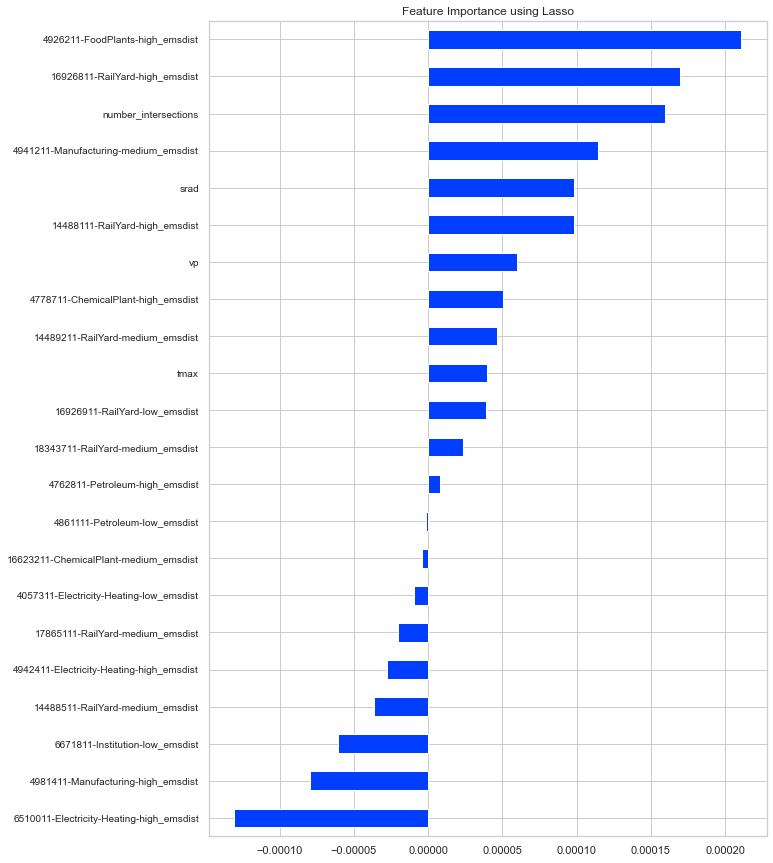

The final set of hyperparameters are: {'alpha': 1e-05}
The Neg. MSE after tuning is: -2.65918672898003e-07


In [7]:
def lasso_model(X_arr, y_arr, grid_param, cols):
    # defining the regressor
    regressor = Lasso(random_state=1)

    # do GridSearchCV
    gd_sr = GridSearchCV(estimator=regressor,
                        param_grid=grid_param,
                        scoring='neg_mean_squared_error',
                        cv=10,
                        n_jobs=-1)

    gd_sr.fit(X_arr, y_arr)
    best_parameters = gd_sr.best_params_
    best_score = gd_sr.best_score_
    
    # feature importance list
    coef = pd.Series(gd_sr.best_estimator_.coef_, index = cols)
    print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    
    # plotting the selected features
    feat_imp = coef[coef != 0].sort_values()
    plt.figure(figsize = (10, 15))
    feat_imp.plot(kind = "barh")
    plt.title("Feature Importance using Lasso")
    plt.yticks(fontsize = 10)
    plt.show()
    
    # saving the model to file
    pkl_filename = "lasso_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(gd_sr.best_estimator_, file)
    
    print("The final set of hyperparameters are:", best_parameters)
    print("The Neg. MSE after tuning is:", best_score)
    
    return best_score


grid_param = {
            'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
            }

# building the model
final_score = lasso_model(X_arr, y_arr, grid_param, cols)

# saving tuned model score to master dict
model_scores["Lasso"] = final_score

### (4) Ridge

Ridge picked 82 variables and eliminated the other 0 variables


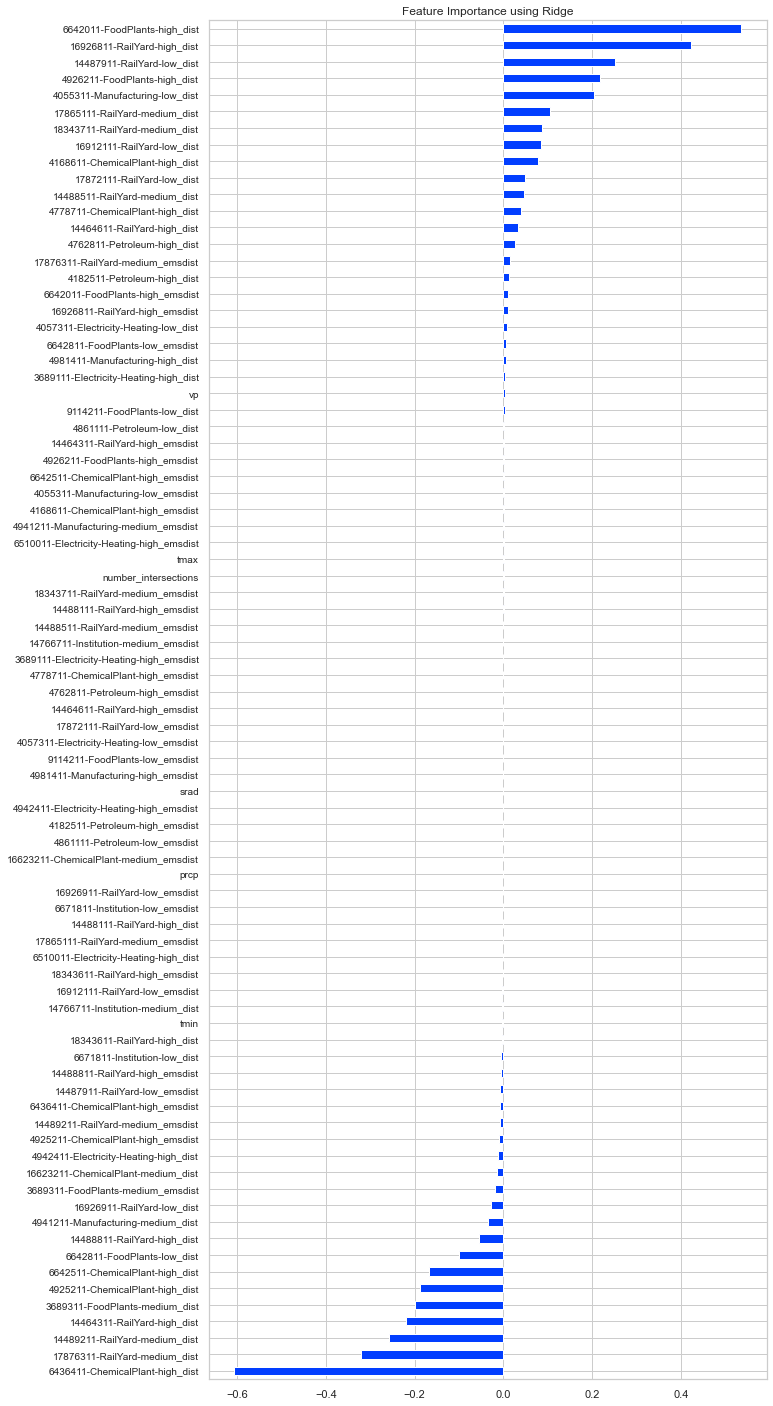

The final set of hyperparameters are: {'alpha': 1e-05, 'solver': 'auto'}
The Neg. MSE after tuning is: -1.8350045158023289e-07


In [9]:
def ridge_model(X_arr, y_arr, grid_param, cols):
    # defining the regressor
    regressor = Ridge(random_state=1)

    # do GridSearchCV
    gd_sr = GridSearchCV(estimator=regressor,
                        param_grid=grid_param,
                        scoring='neg_mean_squared_error',
                        cv=10,
                        n_jobs=-1)

    gd_sr.fit(X_arr, y_arr)
    best_parameters = gd_sr.best_params_
    best_score = gd_sr.best_score_
    
    # feature importance list
    coef = pd.Series(gd_sr.best_estimator_.coef_, index = cols)
    print("Ridge picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    
    # plotting the selected features
    feat_imp = coef[coef != 0].sort_values()
    plt.figure(figsize = (10, 25))
    feat_imp.plot(kind = "barh")
    plt.title("Feature Importance using Ridge")
    plt.yticks(fontsize = 10)
    plt.show()
    
    # saving the model to file
    pkl_filename = "ridge_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(gd_sr.best_estimator_, file)
    
    print("The final set of hyperparameters are:", best_parameters)
    print("The Neg. MSE after tuning is:", best_score)
    
    return best_score


grid_param = {
            'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
            'solver':['auto', 'svd', 'cholesky', 'sag'] 
            }

# building the model
final_score = ridge_model(X_arr, y_arr, grid_param, cols)

# saving tuned model score to master dict
model_scores["Ridge"] = final_score

### (5) Linear regression -- With and without PCA

In [10]:
def linear_model(X_arr, y_arr, cols, pca_flag=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, 
                                                    test_size=0.3)
    if pca_flag:
        pca = PCA(.95)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
        
        # saving model to file
        pkl_filename = "pca.pkl"
        with open(pkl_filename, 'wb') as file:
            pickle.dump(pca, file)
        
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = - mean_squared_error(y_test, y_pred)
    
    # saving regression model to file
    pkl_filename = "linear_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

    print("Neg. MSE is:", score)
    
    return score


# building the linear model without PCA
final_score = linear_model(X_arr, y_arr, cols)
model_scores["Linear"] = final_score

# building the linear model with PCA feature selection
final_score = linear_model(X_arr, y_arr, cols, pca_flag=True)
model_scores["Linear(PCA)"] = final_score

Neg. MSE is: -1.7429402374949595e-07
Neg. MSE is: -3.013181658827342e-07


## (C) Model evaluation / Error analysis

<Figure size 720x504 with 0 Axes>

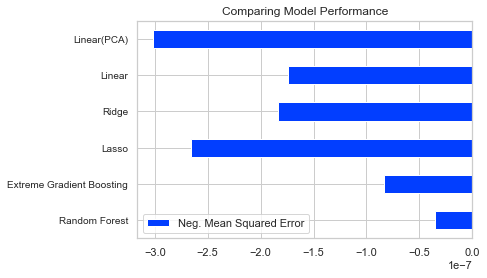

In [21]:
model_scores_df = pd.DataFrame.from_dict(model_scores, orient = 'index')
model_scores_df.columns = ["Neg. Mean Squared Error"]
plt.figure(figsize = (10, 7))
model_scores_df.plot(kind = "barh", title = "Comparing Model Performance")
axes = plt.gca()
plt.yticks(fontsize = 10)
plt.show()

## (D) Predictions

## (E) Archive

### Linear model with RFE

In [22]:
def linear_model(X_arr, y_arr, cols):
    
    ## determining optimum no of features
    
    nof_list=np.arange(1,len(cols))            
    neg_score=float(np.inf)
    nof=0           
    
    for n in range(len(nof_list)):
        model = LinearRegression()
        rfe = RFE(model,nof_list[n])
        X_rfe = rfe.fit_transform(X_arr,y_arr)
        cv_score_list = cross_val_score(model, X_rfe, 
                                        y_arr, cv=5, scoring='neg_mean_squared_error')
        
        if(cv_score_list.mean() < neg_score):
            neg_score = cv_score_list.mean()
            nof = nof_list[n]
            
    ## getting list of optimum features
    
    model = LinearRegression()

    # initializing RFE model
    rfe = RFE(model, nof)    

    # transforming data using RFE
    X_rfe = rfe.fit_transform(X_arr,y_arr)

    # fitting the data to model
    model.fit(X_rfe, y_arr)
    
    # saving model to file
    pkl_filename = "linear_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

    temp = pd.Series(rfe.support_, index = cols)
    selected_features_rfe = temp[temp==True].index

    print("Optimum number of features: %d" %nof)
    print("Selected features:", selected_features_rfe)
    print("Score with %d features: %f" % (nof, neg_score))
    
    return neg_score


# building the model
final_score = linear_model(X_arr, y_arr, cols)

# saving tuned model score to master dict
model_scores["Linear RFE"] = final_score

Optimum number of features: 1
Selected features: Index(['4941211-Manufacturing-medium_dist'], dtype='object')
Score with 1 features: -0.000000


### Feature selection via Filter method

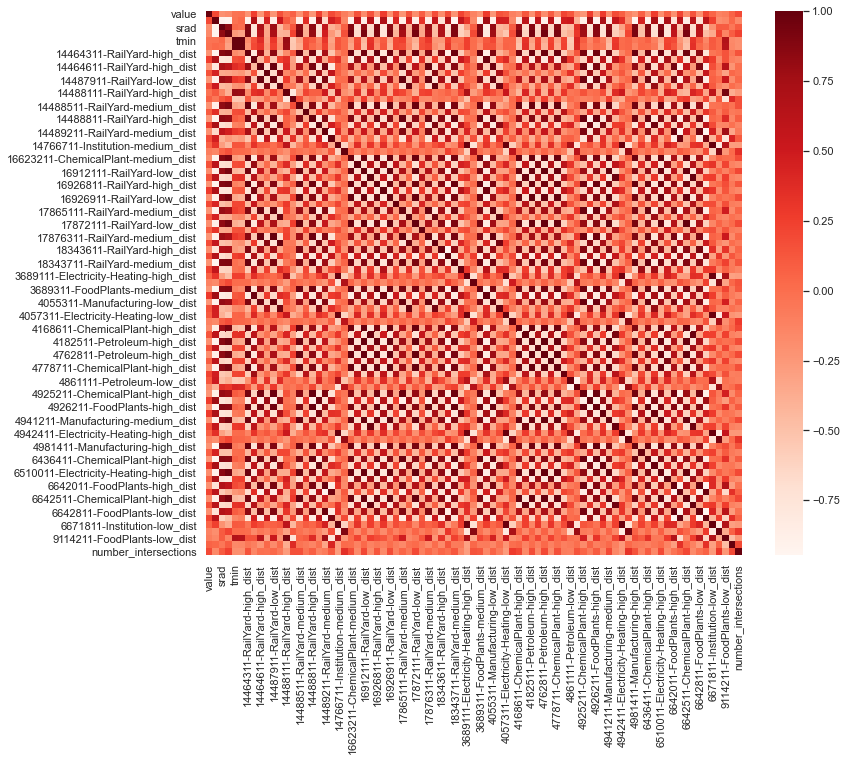

Features in dataset that are not highly correlated: 
Index(['14464311-RailYard-high_dist', '14464311-RailYard-high_emsdist',
       '14464611-RailYard-high_dist', '14488811-RailYard-high_emsdist',
       '18343711-RailYard-medium_emsdist',
       '4778711-ChemicalPlant-high_emsdist',
       '4926211-FoodPlants-high_emsdist'],
      dtype='object')


In [23]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_merged.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

#Correlation with output variable
cor_target = abs(cor["value"])
#Selecting highly correlated features
relevant_features = cor_target[(cor_target>0.2) & (cor_target != 1.0)]  # anything above 0.2 gives nothing
relevant_features

# removing features with high levels of multicollinearity
selected_features_corr = df_merged[list(relevant_features.index)].corr()

# identifying all the features that have a correlation higher than 0.90 or lower than -0.90 indicating a strong positive or negative correlation

threshold_1 = 0.90
threshold_2 = -0.90

def features_high_corr(df_features_corr):
    columns = np.full((df_features_corr.shape[0],), True, dtype=bool)
    for i in range(df_features_corr.shape[0]):
        for j in range(i+1, df_features_corr.shape[0]):
            if (df_features_corr.iloc[i,j] >= threshold_1) | (df_features_corr.iloc[i,j] <= threshold_2) :
                if columns[j]:
                    columns[j] = False
    selected_columns = df_features_corr.columns[columns]
    return selected_columns

# list of features that are not highly correlated
selected_features = features_high_corr(selected_features_corr)
print("Features in dataset that are not highly correlated: ")
print(selected_features)